In [6]:
import os
print(os.getcwd())  # C:\Users\chung\Documents\04-Insight\insight\notebooks
os.chdir('../')
print(os.getcwd())  # C:\Users\chung\Documents\04-Insight\insight

from NextPick.image_search import *
import plotly.express as px
import pickle
from time import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline
import torch
from torchvision import transforms as trn
from annoy import AnnoyIndex
from geopy.geocoders import Nominatim

C:\Users\chung\Documents\04-Insight\insight\notebooks
C:\Users\chung\Documents\04-Insight\insight


In [2]:
pkl_list = load_pkl_paths('notebooks/data')
input_dataset = ImageDataset('notebooks/data')
bs = 100
image_loader = torch.utils.data.DataLoader(input_dataset, batch_size=bs)
model = load_pretrained_model()

C:\Users\chung\Documents\04-Insight\insight\notebooks
C:\Users\chung\Documents\04-Insight\insight


In [3]:
start = time()
annoy_idx = getVectorIndex(model, image_loader)
end = time()

In [4]:
print('Indices generated in %.2fs.'%(end-start)) #257sec for 2529 images

Indices generated in 2022.21s.


In [8]:
pd_files = input_dataset.get_file_df()

In [16]:
transform = trn.Compose([trn.Resize((256, 256)),
                               trn.CenterCrop(224),
                               trn.ToTensor(),
                               trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                              ])

def eval_test_image(test_img, model, annoy_index, top_n=5):
    '''
    Search for the closest image as the test iamge.
    :param test_img: path of test image
    :param model:
    :param annoy_index:
    :return:
    '''
    with torch.no_grad():
        model.eval()
        data = Image.open(test_img,'r').convert('RGB')
        data = transform(data).unsqueeze(0)
#         img_loader = DataLoader(data)
#         for idx, img in enumerate(img_loader):
        feature = model(data)
    searches = annoy_index.get_nns_by_vector(feature[0], top_n, include_distances=True)
    return searches[0], searches[1]

In [17]:
test_img = 'notebooks/ski-test-img.png'
searches = evalTestImage(test_img, model, annoy_idx)

In [18]:
#tuple of lists
searches

([10191, 10326, 10192, 10330, 3177],
 [0.4446498453617096,
  0.5100016593933105,
  0.5210590362548828,
  0.5307708978652954,
  0.531324565410614])

In [19]:
annoy_path = 'notebooks/annoy_idx.annoy'
annoy_idx.save(annoy_path)

True

In [20]:
if os.path.exists(annoy_path):
    annoy_idx_loaded = AnnoyIndex(512)
    annoy_idx_loaded.load(annoy_path)

C:\test\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  


In [21]:
def plot_input_and_similar(test_img, searches, pd, titles=None):
    '''
    Use this function instead of plot_similar.
    test_img: text path to test image
    searches: tuple of lists. index[0] is a list of similar indices. index[1] is a list of cosine distances (flat_list)
    pd: dataframe of paths
    '''
    idx = searches[0]
    titles = searches[1]
    
    f = plt.figure(figsize=(10,15))
    plt.subplots_adjust(left=0.1, bottom=0, right=0.2, top=1.02, wspace=0.02, hspace=0.02)
    plt.axis('Off')
    rows = len(idx)
    cols = 2
    for i, img_idx in enumerate(idx):
        sp = f.add_subplot(rows, cols, 2*(i+1)) # want the output pictures on the right side
        sp.axis('Off')
        sp.get_xaxis().set_visible(False)
        sp.get_yaxis().set_visible(False)
        if titles is not None:
            sp.set_title('Cosine sim = %.3f'%titles[i], fontsize=16)
        data = Image.open(pd.iloc[img_idx].path, 'r')
        data = data.convert('RGB')
        data = data.resize((400,300), Image.ANTIALIAS)
        plt.imshow(data)
        plt.tight_layout()
    
    #plot test image
    sp = f.add_subplot(rows, cols, rows) # want the test image in the middle of the column
    sp.axis('Off')
    sp.get_xaxis().set_visible(False)
    sp.get_yaxis().set_visible(False)
    sp.set_title('User Input', fontsize=16)
    data = Image.open(test_img, 'r')
    data = data.convert('RGB')
    data = data.resize((400,300), Image.ANTIALIAS)
    plt.imshow(data)
    plt.tight_layout()
        
    plt.autoscale(tight=True)
#     if fig_title is not None:
#         plt.suptitle(titles, size=32)
#         f.tight_layout()
#         f.subplots_adjust(top=0.94)
#         plt.show()

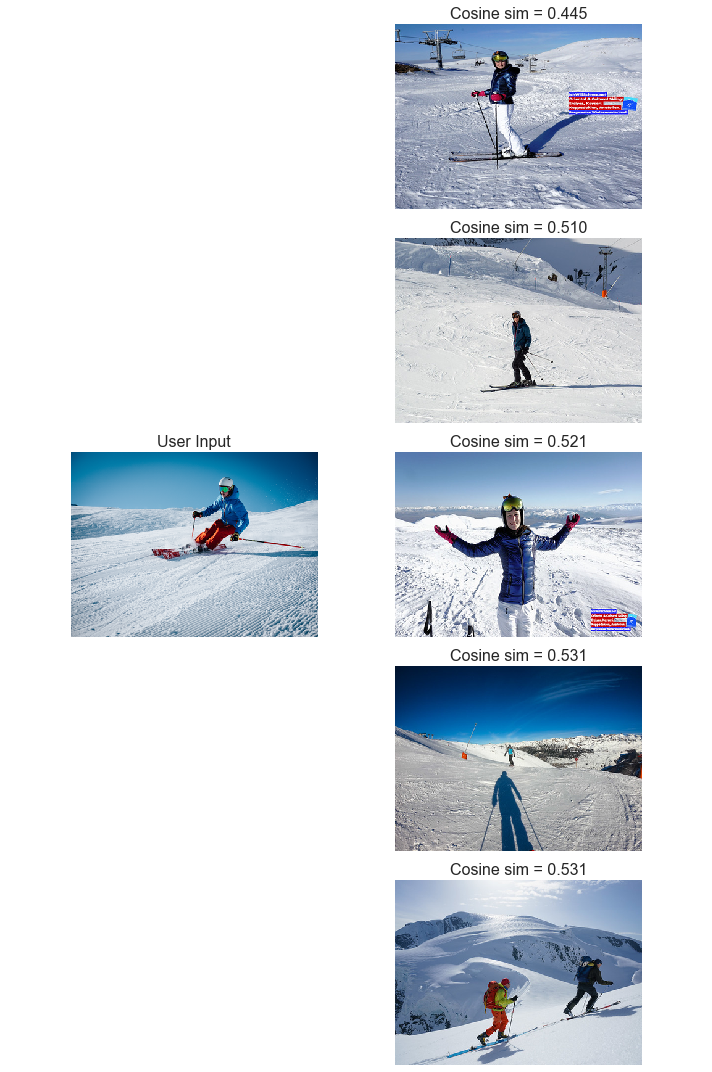

In [22]:
plot_input_and_similar(test_img, searches, pd_files)

In [45]:
def plot_map(searches):
    
    idx = searches[0] #list of annoy index results
    class_labels = list(pd_files.iloc[idx].label.drop_duplicates())
    name = list(pd_files.iloc[idx]['name'].str.rstrip('.jpg')) # list of photo id's
    
    for_plotly = pd.DataFrame(columns=['latitude','longitude'])
    for label in class_labels:
        with open('notebooks/data/%s/%s.pkl'%(label,label), 'rb') as f:
            locations = pickle.load(f)
            for_plotly = pd.concat([locations.loc[locations['id'].isin(name)][['latitude','longitude']],for_plotly])
            f.close()
    for_plotly = for_plotly.reset_index(drop=True)
    keys_for_display = ['country']
    gl = Nominatim(user_agent='default')
    for_plotly['latlon'] = list(zip(for_plotly['latitude'],for_plotly['longitude']))   
    locations = []
    display_names = []
    for i, row in for_plotly.iterrows():
        location = gl.reverse(for_plotly.iloc[i]['latlon'])
        locations.append(location.address)
        display_names.append(str(i+1))
#         display_names.append(", ".join([location.raw['address'][key] for key in keys_for_display]))
#         locations.append(gl.reverse(for_plotly.iloc[i]['latlon']))
#     addresses = [", ".join([location.raw['address'][key] for key in keys_for_address]) for location in locations]  
    for_plotly['address'] = locations
    for_plotly['display'] = display_names
    print(for_plotly)

    fig = px.scatter_geo(for_plotly, lat='latitude', lon='longitude', text='display')
    
    fig.update_traces(textposition="top center",
                      mode='markers+text')
    fig.show()

In [46]:
plot_map(searches)

    latitude  longitude                  latlon  \
0  69.473329  19.891433  (69.473329, 19.891433)   
1  44.585163   6.655455   (44.585163, 6.655455)   
2  46.777266   8.378100   (46.777266, 8.378100)   
3  38.540713  35.518884  (38.540713, 35.518884)   
4  38.546587  35.515086  (38.546587, 35.515086)   

                                             address display  
0                   Lyngen, Troms og Finnmark, Norge       1  
1  Mayt V5, Vallon, Les Florins, Risoul, Briançon...       2  
2  Engstlen-Jochpass, Engstlenalp, Innertkirchen,...       3  
3  Mustafa Asım Köksal Mahallesi, Develi, Kayseri...       4  
4  Tekir Yaylası, Melikgazi, Kayseri, İç Anadolu ...       5  


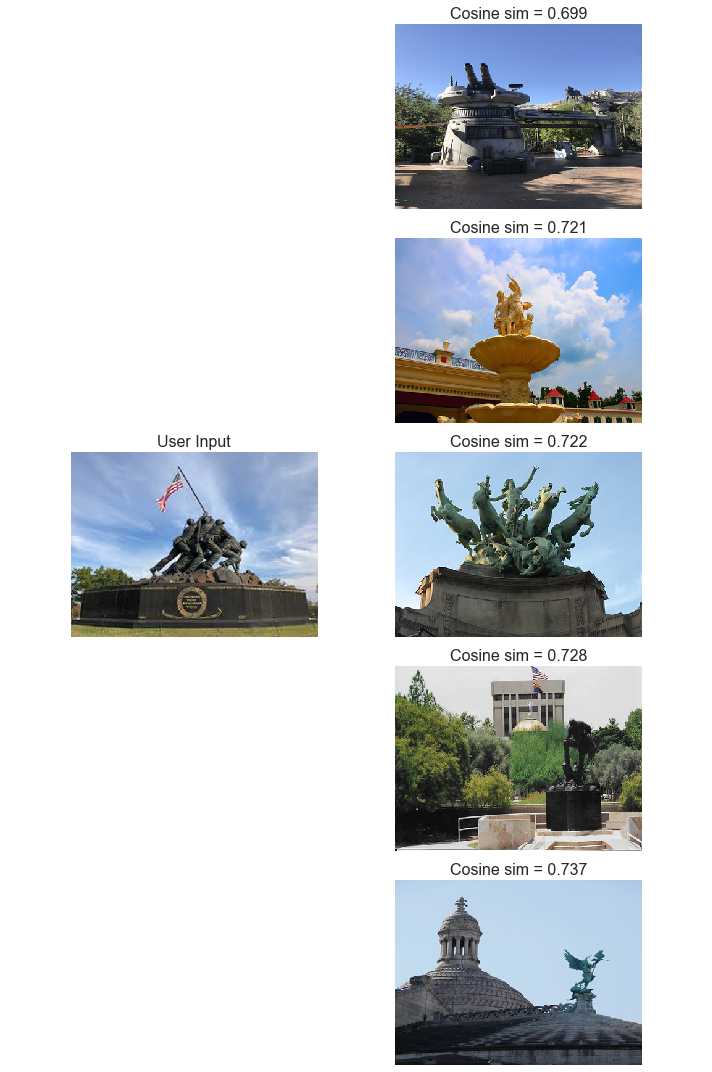

In [25]:
test_img2 = 'notebooks/test-img-war-mem.jpg'
searches2 = eval_test_image(test_img2, model, annoy_idx_loaded)
plot_input_and_similar(test_img2, searches2, pd_files)

In [26]:
plot_map(searches2)

    latitude    longitude                    latlon  \
0  48.887153     2.342931     (48.887153, 2.342931)   
1  33.448344  -112.065353  (33.448344, -112.065353)   
2  48.861496     2.337169     (48.861496, 2.337169)   
3  42.948159   -78.695755   (42.948159, -78.695755)   
4  33.813769  -117.923034  (33.813769, -117.923034)   

                                             address                   display  
0  Basilique du Sacré-Cœur, 35, Rue du Chevalier ...                    France  
1  Arizona Science Center, East Washington Street...  United States of America  
2  Palais du Louvre, Place Colette, Quartier des ...                    France  
3  Salvatore's Garden Place Hotel, Transit Road, ...  United States of America  
4  A-Wing, SWGE Resistance Encampment walkway, Ne...  United States of America  


In [27]:
def create_df_for_map_plot(searches, pd_files):
    '''
    :param searches: search results from evalTestImage()
    :param pd_files: pandas DataFrame from ImageDataset.get_file_df()
    :return: DataFrame of the searches' location and address
    '''
    idx = searches[0]  # list of annoy index results
    class_labels = list(pd_files.iloc[idx].label.drop_duplicates())
    name = list(pd_files.iloc[idx]['name'].str.rstrip('.jpg'))  # list of photo id's

    for_plotly = pd.DataFrame(columns=['latitude', 'longitude'])
    for label in class_labels:
        with open('notebooks/data/%s/%s.pkl' % (label, label), 'rb') as f:
            locations = pickle.load(f)
            for_plotly = pd.concat(
                [locations.loc[locations['id'].isin(name)][['latitude', 'longitude']], for_plotly])
            f.close()

    for_plotly = for_plotly.reset_index(drop=True)
    keys_for_display = ['country']
    gl = Nominatim(user_agent='default')
    for_plotly['latlon'] = list(zip(for_plotly['latitude'], for_plotly['longitude']))
    locations = []
    display_names = []

    for i, row in for_plotly.iterrows():
        location = gl.reverse(for_plotly.iloc[i]['latlon'])
        locations.append(location.address)
        display_names.append(", ".join([location.raw['address'][key] for key in keys_for_display]))
    for_plotly['address'] = locations
    for_plotly['display'] = display_names

    return for_plotly

In [28]:
df1 = create_df_for_map_plot(searches, pd_files)

In [29]:
df1.head()

,latitude,longitude,latlon,address,display
0,69.473329,19.891433,"(69.473329, 19.891433)","Lyngen, Troms og Finnmark, Norge",Norge
1,44.585163,6.655455,"(44.585163, 6.655455)","Mayt V5, Vallon, Les Florins, Risoul, Briançon...",France
2,46.777266,8.378100,"(46.777266, 8.378100)","Engstlen-Jochpass, Engstlenalp, Innertkirchen,...",Switzerland
3,38.540713,35.518884,"(38.540713, 35.518884)","Mustafa Asım Köksal Mahallesi, Develi, Kayseri...",Türkiye
4,38.546587,35.515086,"(38.546587, 35.515086)","Tekir Yaylası, Melikgazi, Kayseri, İç Anadolu ...",Türkiye


In [34]:
df1.address[4]

'Tekir Yaylası, Melikgazi, Kayseri, İç Anadolu Bölgesi, Türkiye'

In [42]:
img_idx = searches[0]
pd_files.iloc[img_idx[4]].path

'notebooks/data\\crevasse\\33853719818.jpg'

In [7]:
from geopy.geocoders import Nominatim
gl = Nominatim(user_agent='default')
location = gl.reverse((44.585163, 6.655455))
location.raw

{'place_id': 571051,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'node',
 'osm_id': 226930842,
 'lat': '44.5867999',
 'lon': '6.6534548',
 'display_name': "Mayt V5, Vallon, Les Florins, Risoul, Briançon, Hautes-Alpes, Provence-Alpes-Côte d'Azur, France métropolitaine, 05600, France",
 'address': {'aerialway': 'Mayt V5',
  'road': 'Vallon',
  'hamlet': 'Les Florins',
  'village': 'Risoul',
  'municipality': 'Briançon',
  'county': 'Hautes-Alpes',
  'state': "Provence-Alpes-Côte d'Azur",
  'country': 'France',
  'postcode': '05600',
  'country_code': 'fr'},
 'boundingbox': ['44.5867499', '44.5868499', '6.6534048', '6.6535048']}